# Test hmov_utils package

This notebook imports and test the output of the ``hmov_code`` package. 

It shows examples of the usage of 
* functions that have time ranges as output (time ranges of opto stimulation etc.), as well as 
* plotting functions implemented in ``hmov_utils``.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [3]:
run -im djd.main -- --dbname=dj_lisa -r

For remote access to work, make sure to first open an SSH tunnel with MySQL
port forwarding. Run the `djdtunnel` script in a separate terminal, with
optional `--user` argument if your local and remote user names differ.
Or, open the tunnel manually with:
  ssh -NL 3306:huxley.neuro.bzm:3306 -p 1021 USERNAME@tunnel.bio.lmu.de
Connecting execute@localhost:3306
Connected to database 'dj_lisa' as 'execute@10.153.172.3'
For remote file access to work, make sure to first mount the filesystem at tunnel.bio.lmu.de:1021 via SSHFS with `hux -r`


In [4]:
from djd import hmov_unit

In [5]:
from hmov_code import hmov_utils

Define Key:

In [6]:
m = 'Ntsr1Cre_2019_0008'
s = 5
e = 8
u = 21

key = {'m': m, 's': s, 'e': e}

## Test functions to get time ranges

Time ranges of the stimulus:

In [7]:
stim_tranges, stim_IDs = (trial & key).get_tranges()
stim_tranges

array([[  61.214 ,  101.2786],
       [ 101.294 ,  281.6264],
       [ 281.6485,  321.7258],
       [ 321.727 ,  502.0451],
       [ 502.048 ,  542.1253],
       [ 542.16  ,  722.497 ],
       [ 722.481 ,  762.5583],
       [ 762.5595,  942.9049],
       [ 942.914 ,  982.9913],
       [ 982.9925, 1163.3285],
       [1163.347 , 1203.4243],
       [1203.4255, 1383.7662],
       [1383.7795, 1423.8568],
       [1423.8585, 1604.2045],
       [1604.1795, 1644.2568],
       [1644.258 , 1824.602 ],
       [1824.612 , 1864.6893]])

Time ranges of the opto events (start and stop of each opto pulse):

In [8]:
evtimesopto = (Event.Times() & {'m': m, 's': s, 'e': e, 'u':u,'ev_chan':'opto1'}).fetch('ev_tranges')

Time ranges of every second (also those that have no opto condition):

In [9]:
tranges_all = hmov_unit.get_all_tranges(key)
tranges_all

    Opto stimulations longer than 1 sec detected.
    Number of opto stimulations excluded due to this: 14


array([[  62.179 ,   63.179 ],
       [  63.181 ,   64.181 ],
       [  64.183 ,   65.183 ],
       ...,
       [1860.713 , 1861.713 ],
       [1861.715 , 1862.715 ],
       [1862.7163, 1863.7163]])

Split into time ranges depending on opto/no-opto condition:

In [10]:
# get the opto, no opto mask
_, _, opto = (spk & key).get_tranges(tranges=tranges_all)
no_opto = ~opto

# get array with time ranges depending on conditon
tranges_opto = tranges_all[opto]
tranges_noopto = tranges_all[no_opto]

Time ranges of the 4 conditons:

In [11]:
# (1) condition: opto on switch 
tranges_opto_on = hmov_unit.get_tranges_cond_swit(tranges_opto)
# (2) condition: opto on continuity
tranges_opto_cont = hmov_unit.get_tranges_cond_cont(tranges_opto)
# (3) condition: opto off switch 
tranges_opto_off = hmov_unit.get_tranges_cond_swit(tranges_noopto)
# (4) condition: no opto continuity
tranges_noopto_cont = hmov_unit.get_tranges_cond_cont(tranges_noopto)

Time ranges of the spontaneous opto condition:

In [12]:
# if remote, you need to mount mudata e.g. sshfs -p 1021 -o follow_symlinks schmors@tunnel.bio.lmu.de:/mudata mudata/
xptranges_spont = hmov_unit.get_xptranges_spont(key)
xptranges_spont

array([[-8.33300000e-03,  6.01077670e+01],
       [ 1.86359237e+03,  1.92370847e+03]])

In [13]:
tranges_spont = hmov_unit.get_all_tranges(key, include_spont=True)

    Opto stimulations longer than 1 sec detected.
    Number of opto stimulations excluded due to this: 14


In [14]:
# get all event time ranges within spontOpto       
evtranges_spont = tranges_spont[util.intersect_tranges(xptranges_spont, tranges_spont)]

# Plotting

## Spike rasters

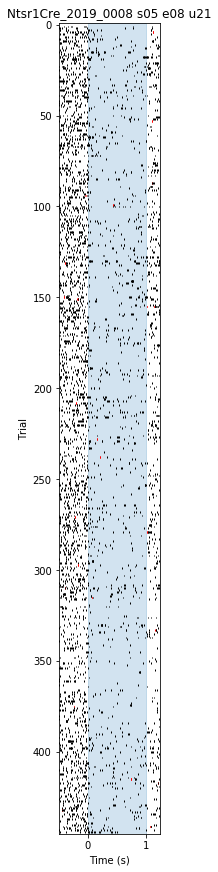

In [15]:
(spk & {'m': m, 's':s, 'e':e, 'u':u}).traster(offsets=[-0.5, 0.25], stimis=False, tranges=tranges_opto_on, title=True, optocolor='k', bursts=True, eventfill=True)

## PSTH of spontaneous opto

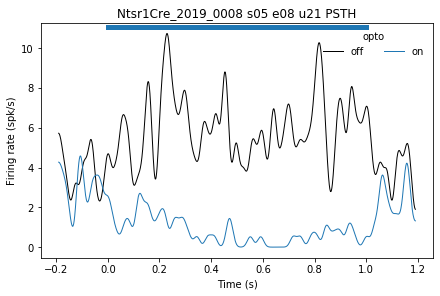

In [16]:
(spk & {'m':m, 's':s, 'e':e, 'u':u}).psth(offsets=[-0.2, 0.2], tranges=evtranges_spont, title=True, eventbar=True)

## Opto effect during visual stimulation

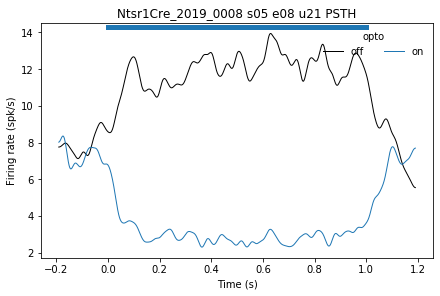

In [17]:
(spk & {'m':m, 's':s, 'e':e,'u':u}).psth(offsets=[-0.2, 0.2], tranges=tranges_all, title=True, eventbar=True)

    Opto stimulations longer than 1 sec detected.
    Number of opto stimulations excluded due to this: 14


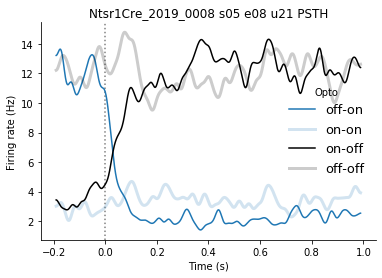

In [18]:
hmov_unit.plot_opto_cond_psth({'m':m, 's':s, 'e':e,'u':u})

    Opto stimulations longer than 1 sec detected.
    Number of opto stimulations excluded due to this: 14


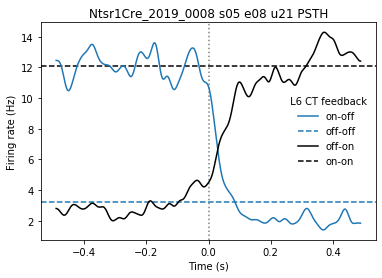

In [19]:
hmov_utils.psth_cond_base({'m':m, 's':s, 'e':e,'u':u})

## Firing rate as bar graph

    Opto stimulations longer than 1 sec detected.
    Number of opto stimulations excluded due to this: 14


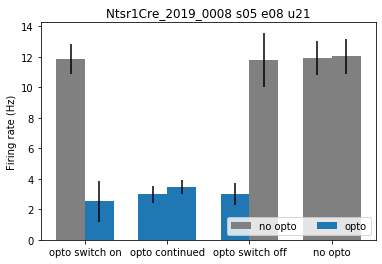

In [20]:
units = [21]

for ukey in units:
    u = ukey
    hmov_utils.bar_cond(m, s, e, u)
    #plt.savefig(('plots/Ntsr1Cre_2019_0003_s04_e05_u'+str(ukey)+'.png'), dpi = 300)